# Naive Bayes

Recall that in generative modelling, we model the distribution $\mathbb{P}\{X|Y\}$. In linear and quadratic discriminant analysis, the distribution is modeled as a normal distribution. Letting $X=[X_1, X_2,..., X_d]$, where $X_i$ denote the features of $X$, then 

$$\mathbb{P}\{X|Y\}= \mathbb{P}\{X_1, X_2,..., X_d|Y\}$$

In Naive Bayes, we place an assumption that the features are conditionally independent given $Y$, i.e.

$$\mathbb{P}\{X|Y\}= \mathbb{P}\{X_1|Y\}\mathbb{P}\{X_2|Y\}...\mathbb{P}\{X_d|Y\}$$

We then model $\mathbb{P}\{X_i|Y\}$ depending on whether $X_i$ is discrete or continuous. 

## Gaussian Naive Bayes

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [7]:
mean1 = [1, 1]
mean2 = [-5, -1]
mean3 = [-2, 3]
cov = [[1, 0], [0, 3]]

class1 = np.random.multivariate_normal(mean1, cov, 50)
class2 = np.random.multivariate_normal(mean2, cov, 50)
class3 = np.random.multivariate_normal(mean3, cov, 50)

X = np.concatenate((class1, class2, class3), axis=0)
y = np.array([0] * 50 + [1] * 50 + [2] * 50)

print(f"Shape of feature matrix: {X.shape}")
print(f"Shape of response matrix: {y.shape}")

Shape of feature matrix: (150, 2)
Shape of response matrix: (150,)


In [133]:
class GaussianNaiveBayes:
    
    def __init__(self, D, K):
        self.mu = np.zeros((K, D))
        self.sigma = np.zeros((K, D))
        self.prior = np.zeros(K, )
        self.K = K
        
    def fit(self, X, y):
        N, D = X.shape
        for k in range(self.K):
            X_k = X[y == k]
            self.mu[k, :] = X_k.mean(axis=0)
            self.sigma[k, :] = X_k.std(axis=0)
            self.prior[k] = X_k.shape[0] / float(N)
    
    def predict(self, X):
        N = X.shape[0]
        probs = np.zeros((N, self.K))
        classes = np.zeros(N)
        for i in range(N):
            for k in range(self.K):
                likelihood = np.prod(self.prob(X[i], self.mu[k], self.sigma[k]))
                probs[i, k] = self.prior[k] * likelihood
            classes[i] = np.argmax(probs[i, :])
        return classes, np.exp(probs)

    def prob(self, X, mu, sigma):
        sigma = np.where(sigma == 0, 1e-6, sigma)
        coeff = 1 / (sigma * np.sqrt(2 * np.pi))
        exponent = np.exp(-0.5 * ((X - mu) ** 2) / (sigma ** 2))
        return coeff * exponent

In [109]:
naive = GaussianNaiveBayes(2, 3)
naive.fit(X, y)

In [110]:
h = 0.05

cmap_light = ListedColormap(['#FFAAAA66', '#AAFFAA66', '#AAAAFF66'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min, x_max = -7, 3
y_min, y_max = -4.5, 7
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z, _ = naive.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.array(Z).reshape(xx.shape)

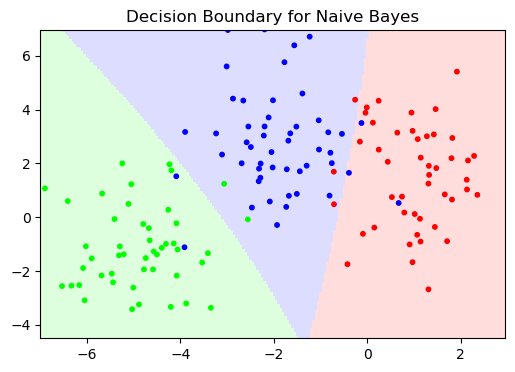

In [112]:
plt.figure(figsize=(6, 4))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=10)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Decision Boundary for Naive Bayes")
plt.show()

## Bernoulli Naive Bayes

In [141]:
import pandas as pd
import requests, zipfile, io
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [115]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
dataset_zip = "smsspamcollection.zip"

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall(".")

df = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=['label', 'message'])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head(5)

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [142]:
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=0)
vectorizer = CountVectorizer(binary=True)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [152]:
class BernoulliNaiveBayes:
    
    def __init__(self, D, K, laplace_smoothing=0):
        self.prob = np.zeros((K, D))
        self.prior = np.zeros(K, )
        self.L = laplace_smoothing
        self.K = K
        
    def fit(self, X, y):
        N, D = X.shape
        for k in range(self.K):
            X_k = X[y == k]
            self.prob[k, :] = (X_k.sum(axis=0) + self.L) / (X_k.sum(axis=0) + self.L * self.K)
            self.prior[k] = X_k.shape[0] / float(N)
    
    def predict(self, X):
        N = X.shape[0]
        probs = np.zeros((N, self.K))
        classes = np.zeros(N)
        for i in range(N):
            for k in range(self.K):
                likelihood = np.prod(np.where(X[i] * self.prob[k] == 0, 1, X[i] * self.prob[k]))
                probs[i, k] = self.prior[k] * likelihood
            classes[i] = np.argmax(probs[i, :])
        return classes, np.exp(probs)

In [157]:
naive = BernoulliNaiveBayes(7793, 2, 1)
naive.fit(X_train, y_train)
classes, _ = naive.predict(X_test)
print(f"Test accuracy: {np.sum((classes == y_test)) / len(y_test)}")

Test accuracy: 0.9533632286995516
